# Exploratory Data analysis
## Our goal is to predict the location of the gate that is on the image. If the gate is not fully visible than we will need to inform the user that the gate is not fully visible. The main purpose of this EDA is to analyse the data that we have and see if there are any problems with the data that we will need to solve later. Also the analysis of the data will help us in deciding how we should aproach a given problem
### Part 1 - import libraries and load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
import copy

In [2]:
DIR_DATA = '../data'
COLUMN_NAMES = ['detected', 'center_x', 'center_y', 'width', 'height']

In [3]:
images = []
info_images = pd.DataFrame(columns=COLUMN_NAMES)

for file in glob.glob(os.path.join(DIR_DATA, '*.jpg')):
    images.append(cv2.imread(file))
    # Read txt file corresponding to read image
    with open(file.replace("jpg", "txt")) as f:
        data = f.readline().split()
        # readline will read everything as string. We need to convert the values to float
        data = map(float, data)
        data = dict(zip(COLUMN_NAMES, data))
        info_images = info_images.append(data, ignore_index=True)

In [4]:
images = np.array(images)
images.shape

(1023, 500, 800, 3)

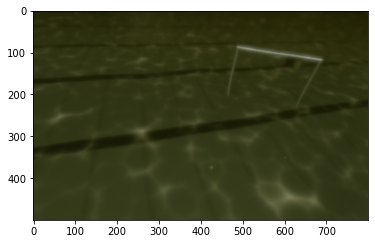

In [5]:
# I choose [1] instead of [0] because firstly I want to analyse case where whole gate is visible
plt.imshow(images[1])
plt.show()

In [6]:
info_images.head()

,detected,center_x,center_y,width,height
0,1.0,0.608578,0.152944,0.282680,0.372754
1,1.0,0.680503,0.356692,0.371274,0.454479
2,1.0,0.552284,0.292856,0.262413,0.640676
3,1.0,0.601670,0.359764,0.109698,0.182384
4,1.0,0.481938,0.000000,0.786607,2.486018


In [7]:
info_images.dtypes

detected    float64
center_x    float64
center_y    float64
width       float64
height      float64
dtype: object

In [8]:
info_images['detected'].value_counts()

1.0    1023
Name: detected, dtype: int64

We can notice a few important things from loading the data:
1. We have 1023 images. That is not a lot. We may be forced to use data augmentation techniques (transpose, rotation etc.) to improve the performance of our model
2. All images have shape of 800 x 500 pixels. That's a good thing because we won't be forced to reshape images so that they would fit our model
3. We will need to analyse how exactly center_x, center_y, width and height correspond to the image. We can see that the values are between 0 and 1. It may be possible that these values were divided by the width and height of the image but we will need to check that out
4. We can see / partially see gate on every image. That's a good and a bad thing at the same time because on one hand we won't be forced to analyse the case where there is no gate visible but on the other hand it would be a good idea to include the fact that the robot won't always see the gate in our analysis
5. If we look at the x_axis and y_axis on the image we will see that x_axis goes from left to right while y_axis goes from up to down. This may be important later

### Part 2 - check how center_x, center_y, width and height correspond to the image
Note - we will try to avoid using matplotlib.pyplot functionalities and use cv2 functionalities unless it's necessary to use matplotlib.pyplot functionalities

In [9]:
_, image_height, image_width, _ = images.shape

In [10]:
image = images[1]
center_x = info_images['center_x'][1]
center_y = info_images['center_y'][1]
width = info_images['width'][1]
height = info_images['height'][1]

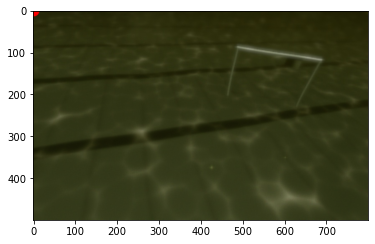

In [11]:
# Completely incorrect
gate_center = (int(center_x), int(center_y))
image_circle = cv2.circle(copy.deepcopy(image), gate_center, 15, (255, 0, 0), -1)
plt.imshow(image_circle)
plt.show()

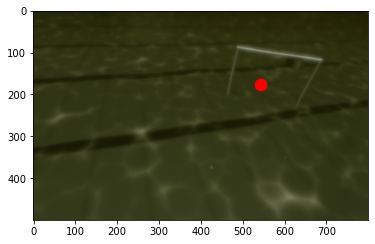

In [12]:
# Correct location in the center
gate_center = (int(center_x * image_width), int(center_y * image_height))
image_circle = cv2.circle(copy.deepcopy(image), gate_center, 15, (255, 0, 0), -1)
plt.imshow(image_circle)
plt.show()

Now we will try to plot the whole gate

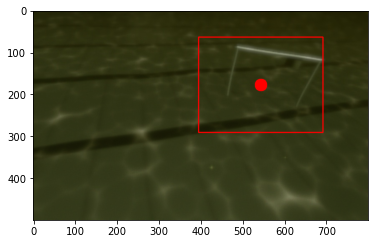

In [13]:
gate_center = (int(center_x * image_width), int(center_y * image_height))
top_left_corner = (int((center_x - width / 2) * image_width), int((center_y - height / 2) * image_height))
bottom_right_corner = (int((center_x + width / 2) * image_width), int((center_y + height / 2) * image_height))

image_circle = cv2.circle(copy.deepcopy(image), gate_center, 15, (255, 0, 0), -1)
image_with_gate = cv2.rectangle(image_circle, top_left_corner, bottom_right_corner, (255, 0, 0), 2)
plt.imshow(image_with_gate)
plt.show()

We were able to derive all the formulas needed to locate the gate on the given image. Now we will apply all these formulas to our dataframe

In [14]:
info_images['center_x'] = info_images['center_x'] * image_width
info_images['center_y'] = info_images['center_y'] * image_height
info_images['width'] = info_images['width'] * image_width
info_images['height'] = info_images['height'] * image_height
info_images.head()

,detected,center_x,center_y,width,height
0,1.0,486.862640,76.472225,226.144216,186.377140
1,1.0,544.402120,178.345980,297.019440,227.239265
2,1.0,441.826912,146.427990,209.930560,320.338050
3,1.0,481.335736,179.882020,87.758112,91.192185
4,1.0,385.550520,0.000000,629.285920,1243.008850


In [15]:
info_images['top_left_x'] = info_images[['center_x', 'width']].apply(lambda x: int(x[0] - x[1] / 2), axis=1)
info_images['top_left_y'] = info_images[['center_y', 'height']].apply(lambda x: int(x[0] - x[1] / 2), axis=1)
info_images['bottom_right_x'] = info_images[['center_x', 'width']].apply(lambda x: int(x[0] + x[1] / 2), axis=1)
info_images['bottom_right_y'] = info_images[['center_y', 'height']].apply(lambda x: int(x[0] + x[1] / 2), axis=1)
info_images.head()

,detected,center_x,center_y,width,height,top_left_x,top_left_y,bottom_right_x,bottom_right_y
0,1.0,486.862640,76.472225,226.144216,186.377140,373,-16,599,169
1,1.0,544.402120,178.345980,297.019440,227.239265,395,64,692,291
2,1.0,441.826912,146.427990,209.930560,320.338050,336,-13,546,306
3,1.0,481.335736,179.882020,87.758112,91.192185,437,134,525,225
4,1.0,385.550520,0.000000,629.285920,1243.008850,70,-621,700,621


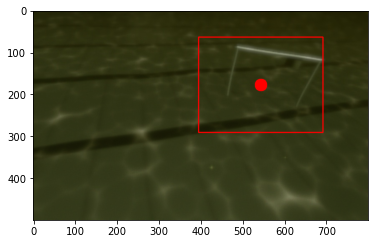

In [16]:
# Test if we have done everything correctly
gate_center = (int(info_images['center_x'][1]), int(info_images['center_y'][1]))
top_left_corner = (info_images['top_left_x'][1], info_images['top_left_y'][1])
bottom_right_corner = (info_images['bottom_right_x'][1], info_images['bottom_right_y'][1])

image_circle = cv2.circle(copy.deepcopy(images[1]), gate_center, 15, (255, 0, 0), -1)
image_with_gate = cv2.rectangle(image_circle, top_left_corner, bottom_right_corner, (255, 0, 0), 2)
plt.imshow(image_with_gate)
plt.show()

Our formulas are correct. But we can see that sometimes we get negative coordinates for our gate. Let's analyse this closer

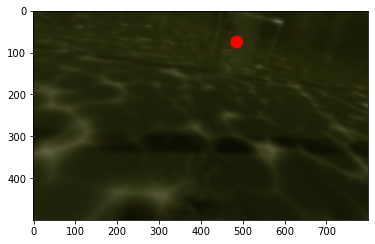

In [17]:
gate_center = (int(info_images['center_x'][0]), int(info_images['center_y'][0]))
image_circle = cv2.circle(copy.deepcopy(images[0]), gate_center, 15, (255, 0, 0), -1)
plt.imshow(image_circle)
plt.show()

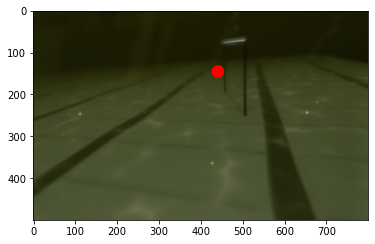

In [18]:
gate_center = (int(info_images['center_x'][2]), int(info_images['center_y'][2]))
image_circle = cv2.circle(copy.deepcopy(images[2]), gate_center, 15, (255, 0, 0), -1)
plt.imshow(image_circle)
plt.show()

If we look at the first image we will see that sometimes the gate won't be fully visible and that's why we won't be able to plot the gate. If we look at the second image we will notice that the gate is fully visible but our code wasn't able to catch it. It also failed to locate the center of the gate. It may be due to the angle at which the gate is positioned. Unfortunately there is nothing that we can do about it.
### Part 3 - analysing the position of the gate
There are 5 possibilities that the gate may be located:
1. The gate is fully visible
2. The gate is to the left (top_left_x < 0)
3. The gate is to the right (bottom_right_x > 800) (bottom_right_x > image_width)
4. The gate is to the down (bottom_right_y > 500) (bottom_right_y > image_height)
5. The gate is to the up (top_left_y < 0)

We won't analyse case when gate isn't visible (because we have no such pictures). We also won't analyse cases like gate is to the left up because that would add too much complexity and there aren't too many images to work with

In [19]:
# The order of gate location was constructed in such a way that we would get a sensible amount of examples for 
# every possible situation
def get_gate_location(info_image: pd.Series, image_height: int, image_width: int) -> str:
    if info_image['bottom_right_x'] > image_width:
        return "Right"
    elif info_image['top_left_x'] < 0:
        return "Left"
    elif info_image['bottom_right_y'] > image_height:
        return "Down"
    elif info_image['top_left_y'] < 0:
        return "Up"
    else:
        return "Fully visible"

In [20]:
info_images['gate_location'] = info_images.apply(lambda x: get_gate_location(x, image_height, image_width), axis=1)
info_images.head()

,detected,center_x,center_y,width,height,top_left_x,top_left_y,bottom_right_x,bottom_right_y,gate_location
0,1.0,486.862640,76.472225,226.144216,186.377140,373,-16,599,169,Up
1,1.0,544.402120,178.345980,297.019440,227.239265,395,64,692,291,Fully visible
2,1.0,441.826912,146.427990,209.930560,320.338050,336,-13,546,306,Up
3,1.0,481.335736,179.882020,87.758112,91.192185,437,134,525,225,Fully visible
4,1.0,385.550520,0.000000,629.285920,1243.008850,70,-621,700,621,Down


In [21]:
info_images['gate_location'].value_counts()

Fully visible    695
Up               238
Down              36
Right             33
Left              21
Name: gate_location, dtype: int64

We can see that we have a lot of fully visible gates. We also have a lot of gates that are up. We don't have a lot of images that are located to the down, left or right.
### Part 4 - data augmentation
We didn't talk about data augmentation techniques but it's worth mentioning them before we jump to conclusions
There are many data augmentation techniques but the easiest one to implement is simply flipping the image by it's x-axis. It can be done quickly and will increase by 2x the number of images that we can train on
An example of flipping is shown below

PS: It's important to note that if the image is flipped that the gate that was located to the left will now be located to the right and vice versa

PS2: Also it's important to remember how bottom_right_x and top_left_x behave when flipping the image

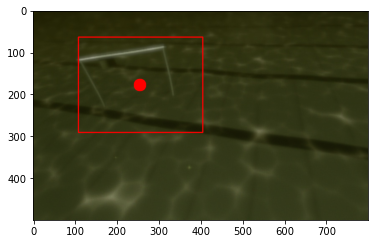

In [22]:
gate_center = (int(image_width - info_images['center_x'][1]), int(info_images['center_y'][1]))
top_left_corner = (image_width - info_images['bottom_right_x'][1], info_images['top_left_y'][1])
bottom_right_corner = (image_width - info_images['top_left_x'][1], info_images['bottom_right_y'][1])

flipped_image = cv2.flip(copy.deepcopy(images[1]), 1)
flipped_image_circle = cv2.circle(flipped_image, gate_center, 15, (255, 0, 0), -1)
flipped_image_with_gate = cv2.rectangle(flipped_image_circle, top_left_corner, bottom_right_corner, (255, 0, 0), 2)
plt.imshow(flipped_image_with_gate)
plt.show()

### Part 5 - conclusions
From the analysed data we can reach following conclusions on how to aproach the given problem:
1. There are not a lot of images that we can use to train on. Even images that we can train on are sometimes faulty. That means that we shouldn't worry if the results that we get are not the best
2. In preprocessing we will need to divide images into train, val and test set and then perform flipping to increase train set size.
3. We will use the preprocessed data to build our first model (that will be based on convolutions). The goal of the model will be to predict the location of the gate (if it's fully visible and if not then where it is located) - simple classification task
4. We will then use data on which the gate is fully visible and predict the top_left_x, top_left_y, bottom_right_x and bottom_right_y of the gate (we could predict the center of the gate and it's width and height but this method is less reliable that the one proposed) - simple regression task
5. If we have both models trained than we will build a proper visualisation tool that will allow the user to see the performance of the model
6. We will try to optimalise the code to avoid copying it (for instance training loop in both models will look almost identical)